In [1]:
"""Boston housing dataset prices prediction."""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy.stats import mstats

In [2]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('datasets/housing.xls', header=None, delimiter=r"\s+", names=column_names)
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [3]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
data["MEDV"].value_counts()

MEDV
50.0    16
25.0     8
22.0     7
21.7     7
23.1     7
        ..
32.9     1
34.6     1
30.3     1
33.3     1
8.1      1
Name: count, Length: 229, dtype: int64

In [5]:
data['ZN'].value_counts()

ZN
0.0      372
20.0      21
80.0      15
22.0      10
12.5      10
25.0      10
40.0       7
45.0       6
30.0       6
90.0       5
95.0       4
60.0       4
21.0       4
33.0       4
55.0       3
70.0       3
34.0       3
52.5       3
35.0       3
28.0       3
75.0       3
82.5       2
85.0       2
17.5       1
100.0      1
18.0       1
Name: count, dtype: int64

In [6]:
data['CHAS'].value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

In [7]:

def check_outliers(data, columns):
    """Check outliers in specified columns using IQR method."""
    for col in columns:
        Q1 = data[col].quantile(0.01)
        Q3 = data[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        total_count = len(data[col])
        outlier_percentage = (outlier_count / total_count) * 100
        print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")


In [8]:
data[["CRIM", "MEDV"]] = data[["CRIM", "MEDV"]].apply(lambda x: mstats.winsorize(x, limits=[0.15, 0.15]))

In [9]:
# Re-check outliers
check_outliers(data, ["CRIM", "MEDV"])

corr_matrix = data.corr()
important_features = corr_matrix['MEDV'].abs().sort_values(ascending=False).index[:10]  # Top 10 correlated features
data = data[important_features]  # Keep only important features

CRIM: 0 outliers (0.00%)
MEDV: 0 outliers (0.00%)


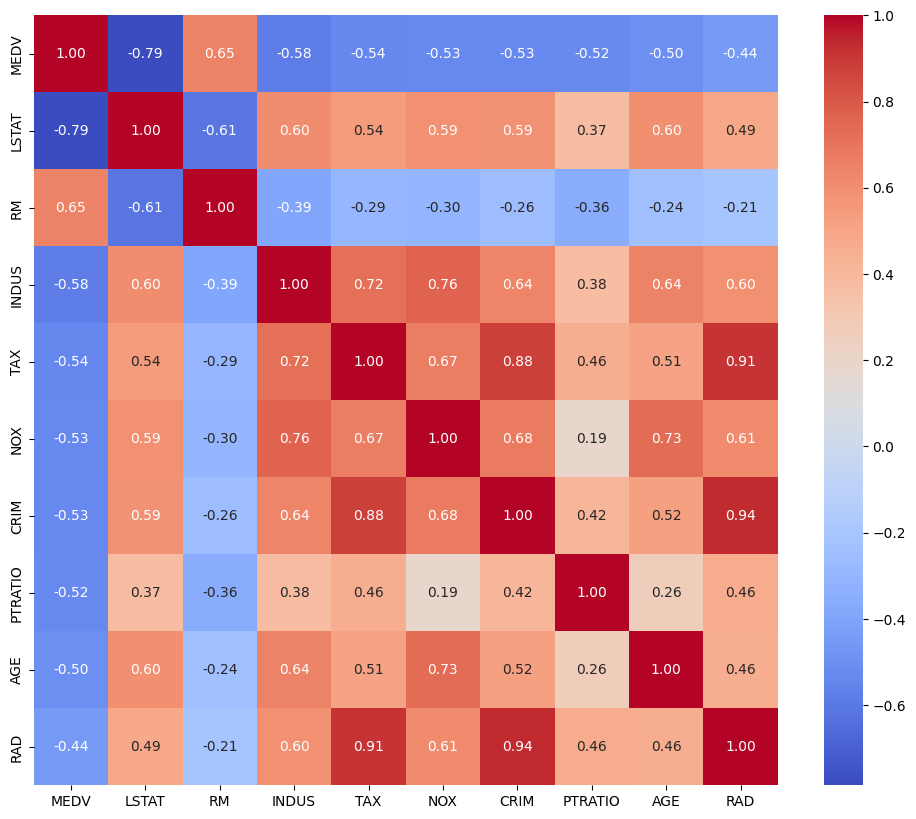

In [10]:
# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

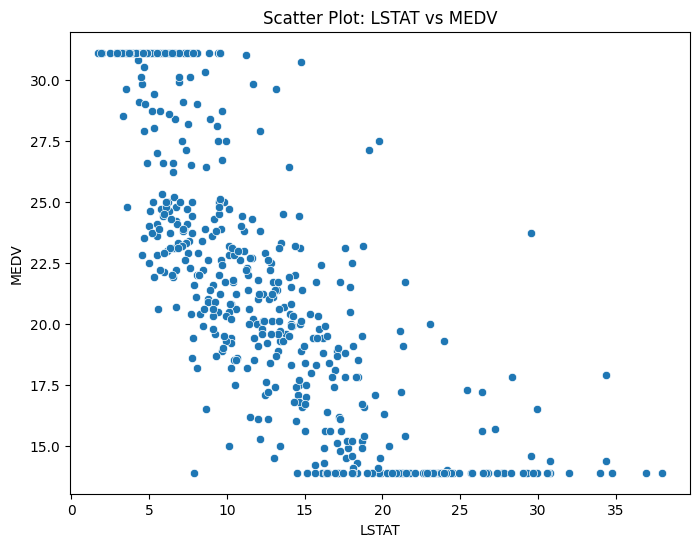

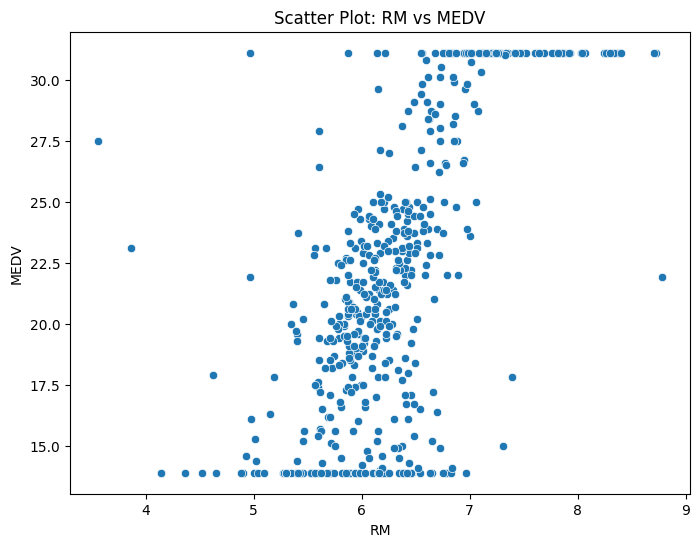

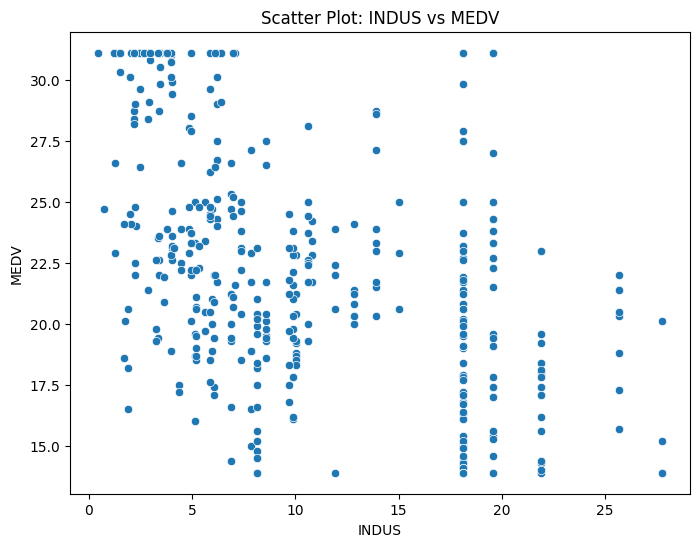

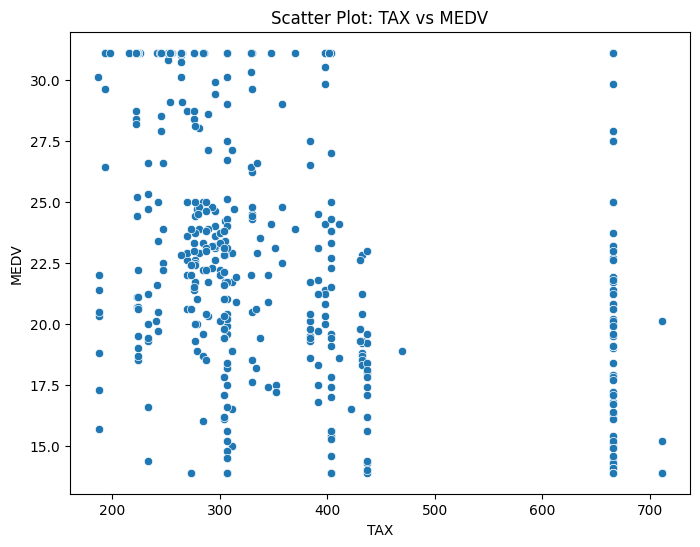

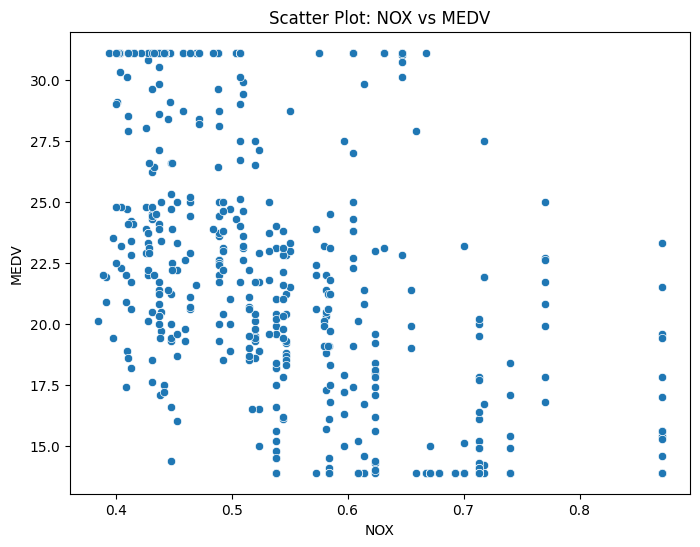

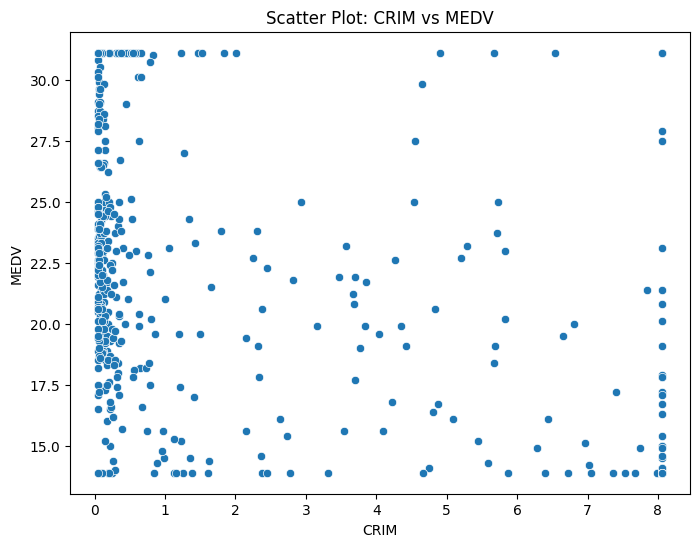

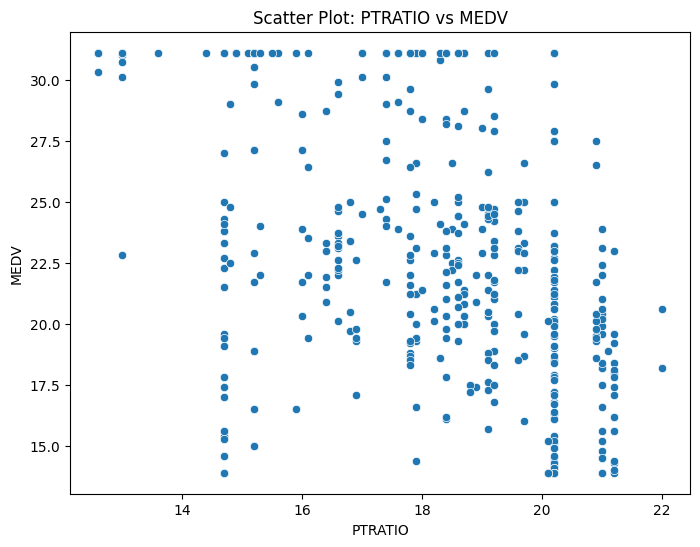

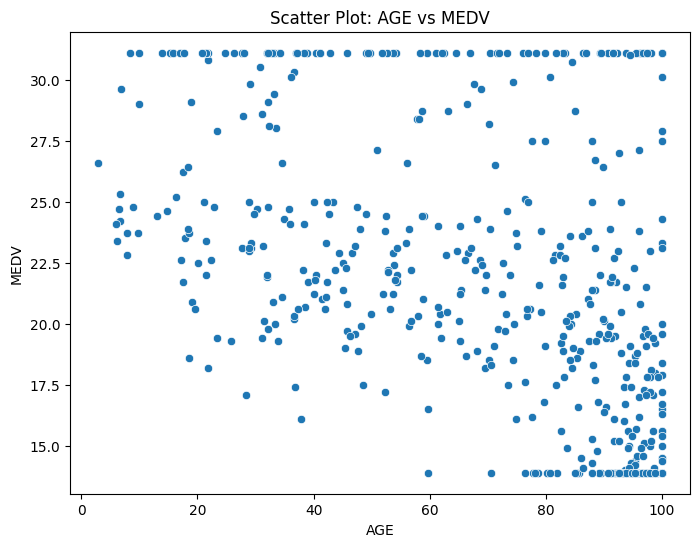

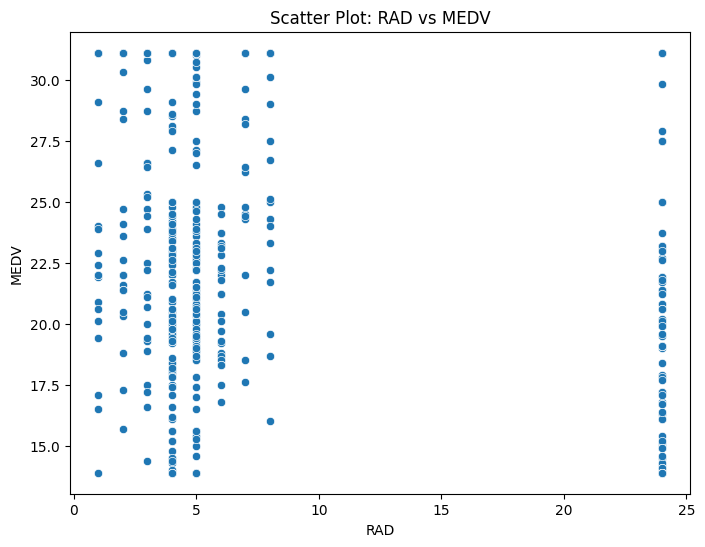

In [11]:
# Generate scatter plots for each feature against the target variable
target_variable = 'MEDV'  # Replace with your actual target variable
for column in data.columns:
    if column != target_variable:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=data[column], y=data[target_variable])
        plt.title(f'Scatter Plot: {column} vs {target_variable}')
        plt.xlabel(column)
        plt.ylabel(target_variable)
        plt.show()

In [12]:
# Normalize Features 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

scaled_data

,MEDV,LSTAT,RM,INDUS,TAX,NOX,CRIM,PTRATIO,AGE,RAD
0,0.587209,0.089680,0.577505,0.067815,0.208015,0.314815,0.000000,0.287234,0.641607,0.000000
1,0.447674,0.204470,0.547998,0.242302,0.104962,0.172840,0.000000,0.553191,0.782698,0.043478
2,1.000000,0.063466,0.694386,0.242302,0.104962,0.172840,0.000000,0.553191,0.599382,0.043478
3,1.000000,0.033389,0.658555,0.063050,0.066794,0.150206,0.000000,0.648936,0.441813,0.086957
4,1.000000,0.099338,0.687105,0.063050,0.066794,0.150206,0.002306,0.648936,0.528321,0.086957
...,...,...,...,...,...,...,...,...,...,...
501,0.494186,0.219095,0.580954,0.420455,0.164122,0.386831,0.001504,0.893617,0.681771,0.000000
502,0.389535,0.202815,0.490324,0.420455,0.164122,0.386831,0.000000,0.893617,0.760041,0.000000
503,0.581395,0.107892,0.654340,0.420455,0.164122,0.386831,0.001270,0.893617,0.907312,0.000000
504,0.470930,0.131071,0.619467,0.420455,0.164122,0.386831,0.007370,0.893617,0.889804,0.000000


In [13]:
# Split the data into training and testing sets
X = scaled_data.drop('MEDV', axis=1)
y = scaled_data['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

In [15]:
models = []

# Train the model
rf.fit(X_train, y_train)

lr.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

y_pred_2 = lr.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
rmse_2 = root_mean_squared_error(y_test, y_pred_2)

r2 = r2_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred_2)

print(f"{rf} - RMSE: {rmse:.4f}, R²: {r2:.4f}")
print(f"{lr} - RMSE: {rmse_2:.4f}, R²: {r2:.4f}")

models.append((rf, rmse))
models.append((lr, rmse_2))

models

RandomForestRegressor(random_state=42) - RMSE: 0.1261, R²: 0.6852
LinearRegression() - RMSE: 0.1752, R²: 0.6852


[(RandomForestRegressor(random_state=42), 0.12611797518631987),
 (LinearRegression(), 0.17521722187283548)]

In [16]:
# Hyperparameter tuning for rf model
params = {
    'n_estimators': [80, 100, 120],
    'max_depth': [25, 30, 35],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

random_search = RandomizedSearchCV(rf, params, n_iter=50, cv=3, scoring='neg_root_mean_squared_error')

random_search.fit(X, y)

# Get best model
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse_3 = root_mean_squared_error(y_test, y_pred)
print(f"Best parameters: {random_search.best_params_}")
print(f"New RMSE: {rmse_3}")

models.append((random_search, rmse_3))
models.sort(key=lambda x: x[1])
models

Best parameters: {'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 35}
New RMSE: 0.05280450746197854


[(RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                     n_iter=50,
                     param_distributions={'max_depth': [25, 30, 35],
                                          'max_features': ['sqrt'],
                                          'min_samples_leaf': [1, 2],
                                          'min_samples_split': [4, 5, 6],
                                          'n_estimators': [80, 100, 120]},
                     scoring='neg_root_mean_squared_error'),
  0.05280450746197854),
 (RandomForestRegressor(random_state=42), 0.12611797518631987),
 (LinearRegression(), 0.17521722187283548)]

## **Kokkuvõte**


Kasutasin 2 regressioonimudelit normaliseeritud andmete põhjal: LR ja Random Forest Regressor. Normaliseerimine on tavaliselt alati kasulik regressioonimudelite jaoks. Alguses kasutasin StandardScalerit ja tulemused olid kehvemad võrreldes MinMaxScaleriga.

Alguses mõtlesin, et hea oleks treenida tunnuste põhjal, millel on tugev korrelatsioon (RM ja LSTAT) sihtmuutujaga (MEDV). Tuli välja, et tulemused olid paremad kui treenida üle kogu andmestiku.

Tegin ka hüperparameetrite tuunimist kõige paremale mudelile (Random Forest Regressor), kasutasin RandomizedSearchCV RMSE parandamiseks, katsetasin erinevaid hüperparameetreid. 

Lõpptulemused (RMSE):

Random Forest Regressor (peale tuunimist) - **0.05280450746197854**

Random Forest Regressor - **0.12611797518631987**

LR - **0.17521722187283553**